## 웹검색 코드를 LangChain Tool 형식으로 전환

#### 기존 코드

In [2]:
import asyncio
from playwright.async_api import async_playwright

async with async_playwright() as p:
    print("🚀 Tesla 기사 제목 추출 시작!")
    
    # 브라우저 실행
    browser = await p.chromium.launch(headless=True)
    page = await browser.new_page()
    
    # Tesla 검색 페이지로 이동
    await page.goto("https://econotimes.com/search?v=tesla&search=")
    await asyncio.sleep(3)


    # XPath를 사용해서 모든 기사 제목 요소 찾기
    general_xpath = '//*[@id="archivePage"]/div/div[2]/div/p[1]/a'
    elements = await page.locator(f"xpath={general_xpath}").all()
    
    print(f"\n📰 발견된 Tesla 기사: {len(elements)}개\n")
    print("=" * 80)
    
    # 각 기사 제목 추출하고 출력
    for i, element in enumerate(elements, 1):
        try:
            # 기사 제목 텍스트 추출
            title = await element.text_content()
            href = await element.get_attribute('href')
            if title and href:
                # 상대 URL을 절대 URL로 변환
                if href.startswith('/'):
                    full_url = f"https://econotimes.com{href}"  #href가 
                else:
                    full_url = href
            
            if title:
                # 제목 출력
                print(f"{i:2d}. {title.strip()}")
                print(f"    🔗 {full_url}")

            
        except Exception as e:
            print(f"{i:2d}. ❌ 추출 실패: {e}")
    
    print("=" * 80)
    print(f"✅ 총 {len(elements)}개의 기사 제목 추출 완료!")
    
    # 브라우저 종료
    await browser.close()

🚀 Tesla 기사 제목 추출 시작!

📰 발견된 Tesla 기사: 15개

 1. Mexico’s 50% Tariff Threatens Tesla and BYD in Booming EV Market
    🔗 https://econotimes.com/Mexicos-50-Tariff-Threatens-Tesla-and-BYD-in-Booming-EV-Market-1720504
 2. Tesla Ordered to Pay $243M in Florida Autopilot Crash Verdict
    🔗 https://econotimes.com/Tesla-Ordered-to-Pay-243M-in-Florida-Autopilot-Crash-Verdict-1717846
 3. Tesla Car Sales in France, Denmark, and Sweden Plunge in July Amid Ongoing European Decline
    🔗 https://econotimes.com/Tesla-Car-Sales-in-France-Denmark-and-Sweden-Plunge-in-July-Amid-Ongoing-European-Decline-1717783
 4. Tesla Secures $4.3B Battery Deal with LG Energy for U.S. Storage Projects
    🔗 https://econotimes.com/Tesla-Secures-43B-Battery-Deal-with-LG-Energy-for-US-Storage-Projects-1717488
 5. Samsung Shares Dip After Rally on $16.5B Tesla Chip Deal
    🔗 https://econotimes.com/Samsung-Shares-Dip-After-Rally-on-165B-Tesla-Chip-Deal-1717364
 6. Tesla Inks $16.5B Chip Deal with Samsung for Next-Gen AI6 P

In [13]:
import asyncio
from playwright.async_api import async_playwright

async with async_playwright() as p:
    print("🚀 Tesla 기사 제목 추출 시작!")
    
    output_list = [] # 결과를 저장할 list 정의
    urls = []

    
    # 브라우저 실행
    browser = await p.chromium.launch(headless=True)
    page = await browser.new_page()
    
    # Tesla 검색 페이지로 이동
    await page.goto("https://econotimes.com/search?v=tesla&search=")
    await asyncio.sleep(3)


    # XPath를 사용해서 모든 기사 제목 요소 찾기
    general_xpath = '//*[@id="archivePage"]/div/div[2]/div/p[1]/a'
    elements = await page.locator(f"xpath={general_xpath}").all()
    
    # 각 기사 제목 추출하고 출력
    for i, element in enumerate(elements, 1):
        try:
            # 기사 제목 텍스트 추출
            title = await element.text_content()
            href = await element.get_attribute('href')
            if title and href:
                # 상대 URL을 절대 URL로 변환
                if href.startswith('/'):
                    full_url = f"https://econotimes.com{href}"
                else:
                    full_url = href
                urls.append(full_url)
            
            if title:
                title = title.strip()
                
        except Exception as e:
            print(f"{i:2d}. ❌ 추출 실패: {e}")

    for url in urls :
        await page.goto(url)
        await asyncio.sleep(1.5)
        # 본문 추출 (copy selector)
        article_text = await page.locator("#view > div.articleViewWrap > div.articleContent > article").text_content()
        article_text = article_text.strip()

        
    output_list.append({'title' : title,
                        'URL' : full_url,
                        'body_content' : article_text})

    # 브라우저 종료
    await browser.close()

🚀 Tesla 기사 제목 추출 시작!


In [14]:
output_list

[{'title': 'Tesla Launches Model Y in India With Starting Price of ₹59.89 Lakh',
  'URL': 'https://econotimes.com/Tesla-Launches-Model-Y-in-India-With-Starting-Price-of-5989-Lakh-1716074',
  'body_content': 'Tesla Inc (NASDAQ:TSLA) has officially launched its Model Y in India, listing prices starting at ₹59.89 lakh (approx. $69,700) for the rear-wheel drive variant. The long-range version is priced at ₹67.89 lakh, according to Tesla’s India website. These prices, which exclude taxes, are significantly higher than the Model Y’s U.S. base price of $44,490 and Bloomberg’s reported $56,000 sticker price. The vehicles will be imported from Tesla’s Shanghai Gigafactory in China. Sales will initially be limited to New Delhi and Mumbai, where Tesla is also opening its first Indian showrooms this July. The Mumbai showroom is expected to open this week, followed by a New Delhi location by month-end. Despite the launch, Tesla has no current plans to set up local manufacturing in India. Previous d

#### 함수로 전환

In [33]:
import asyncio
from playwright.async_api import async_playwright

async def scrape_tesla_articles_with_content(query: str):
    """Econotimes에서 관련 기사 제목, URL, 본문을 스크랩하는 함수"""
    
    
    output_list = [] # 최종 결과를 저장할 리스트

    async with async_playwright() as p:
        # 브라우저 실행
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        await page.goto(f"https://econotimes.com/search?v={query}&search=")
        await asyncio.sleep(1.5)

        # XPath를 사용해서 모든 기사 제목 요소 찾기
        general_xpath = '//*[@id="archivePage"]/div/div[2]/div/p[1]/a'
        elements = await page.locator(f"xpath={general_xpath}").all()


        # 각 기사 제목과 링크 추출
        for element in elements[:4]:
            await page.goto(f"https://econotimes.com/search?v={query}&search=")
            await asyncio.sleep(1.5)

            title = await element.text_content()
            title = title.strip()
            href = await element.get_attribute('href')
            full_url = f"https://econotimes.com{href}" if href.startswith('/') else href
            await page.goto(full_url)
            await asyncio.sleep(1.5)
            # XPath로 본문 추출
            xpath = '//*[@id="view"]/div[2]/div[3]/article'
            article_text = await page.locator(f"xpath={xpath}").text_content()
            article_text = article_text.strip()
            

            output_list.append({
                'title': title,
                'URL': full_url,
                'body_content' : article_text
            })


        
        # 브라우저 종료
        await browser.close()
        
        print("\n" + "=" * 80)
        print(f"✅ 총 {len(output_list)}개의 기사 본문 추출 완료!")
        print("=" * 80)
        return output_list

#### 함수가 잘 작동하는지 테스트

In [34]:
import nest_asyncio

# 이벤트 루프에 패치를 적용합니다.
nest_asyncio.apply()

results = asyncio.run(scrape_tesla_articles_with_content('tesla'))
print(results)


✅ 총 4개의 기사 본문 추출 완료!
[{'title': 'Mexico’s 50% Tariff Threatens Tesla and BYD in Booming EV Market', 'URL': 'https://econotimes.com/Mexicos-50-Tariff-Threatens-Tesla-and-BYD-in-Booming-EV-Market-1720504', 'body_content': 'Mexico’s proposed 50% tariff on vehicles imported from countries without free trade agreements, including China, could deal a major blow to Tesla and BYD while sparing U.S. automakers Ford, GM, and Stellantis. Industry experts say the measure mainly targets Chinese-manufactured electric cars, which have rapidly gained traction in Mexico’s fast-growing EV market. Over the past year, Mexico has raised tariffs on Chinese-made EVs from 0% to 15%, and now plans to raise them to 50%. Eugenio Grandio, president of the Electric Mobility Association in Mexico, called it a “game-changer.” The proposal still awaits approval from Mexico’s Congress, but Morena’s majority makes passage likely. While the tariff is broad, legacy U.S. automakers are protected by a 2003 decree allowing

### LangChain Tool 스타일로 변경

In [70]:
from langchain_core.tools import tool
import asyncio
from playwright.async_api import async_playwright
@tool
async def scrape_tesla_articles_with_content(query: str):
    """
    Econotimes에서 관련 기사 제목, URL, 본문을 스크랩하는 함수
    사용자가 뉴스 검색, 특정 종목에 대한 동향 분석을 요청할 경우 사용합니다.
    예를 들어, tesla에 대한 주식 동향 분석을 요청할 때 이 도구를 이용합니다.
    
    """
    
    output_list = [] # 최종 결과를 저장할 리스트

    async with async_playwright() as p:
        # 브라우저 실행
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        await page.goto(f"https://econotimes.com/search?v={query}&search=")
        await asyncio.sleep(1.5)

        # XPath를 사용해서 모든 기사 제목 요소 찾기
        general_xpath = '//*[@id="archivePage"]/div/div[2]/div/p[1]/a'
        elements = await page.locator(f"xpath={general_xpath}").all()


        # 각 기사 제목과 링크 추출
        for element in elements[:4]:
            await page.goto(f"https://econotimes.com/search?v={query}&search=")
            await asyncio.sleep(1.5)

            title = await element.text_content()
            title = title.strip()
            href = await element.get_attribute('href')
            full_url = f"https://econotimes.com{href}" if href.startswith('/') else href
            await page.goto(full_url)
            await asyncio.sleep(1.5)
            # XPath로 본문 추출
            xpath = '//*[@id="view"]/div[2]/div[3]/article'
            article_text = await page.locator(f"xpath={xpath}").text_content()
            article_text = article_text.strip()
            

            output_list.append({
                'title': title,
                'URL': full_url,
                'body_content' : article_text
            })


        
        # 브라우저 종료
        await browser.close()

        return output_list

In [77]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import json
from langchain_core.messages import ToolMessage, HumanMessage
from typing import TypedDict, Annotated, List, Dict, Optional
from langgraph.prebuilt import ToolNode

class State(TypedDict):
    messages: Annotated[list, add_messages]
    output_list : List[dict]

graph_builder = StateGraph(State)

In [78]:
import os
os.environ["GOOGLE_API_KEY"] = ''

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

tools = [scrape_tesla_articles_with_content]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [79]:
graph_builder = StateGraph(State)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("chatbot", chatbot)

def route_tools(state: State):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)


In [80]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

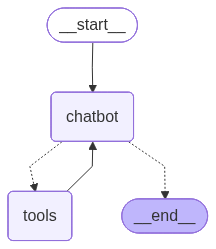

In [81]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [82]:
from langchain_core.messages import AIMessage
def stream_graph_updates_verbose(user_input: str):
    """모든 중간 단계를 자세히 출력하는 함수"""
    inputs = {"messages": [HumanMessage(content=user_input)]}

    print("--- Agent Start ---")
    for event in graph.stream(inputs, stream_mode="values"):
        message = event["messages"][-1]
        
        # AIMessage이면서 tool_calls가 있는 경우 (계획 단계)
        if isinstance(message, AIMessage) and message.tool_calls:
            print(f"🤖 [AIMessage]: Tool Call Planned -> {message.tool_calls[0]['name']}({message.tool_calls[0]['args']})")
        
        # ToolMessage인 경우 (실행 결과)
        elif isinstance(message, ToolMessage):
            print(f"🛠️ [ToolMessage]: Tool Result -> {message.content}")

        # AIMessage이면서 최종 답변인 경우
        elif isinstance(message, AIMessage) and message.content:
            print(f"💬 [AIMessage]: Final Answer -> {message.content}")
    print("--- Agent End ---")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates_verbose(user_input)
    except Exception as e:
        # fallback if input() is not available
        print(f"\n❌ 오류가 발생했습니다: {e}\n")

        import traceback
        traceback.print_exc()
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates_verbose(user_input)
        break

User:  tesla 뉴스 검색 후 동향 분석해줘


--- Agent Start ---
🤖 [AIMessage]: Tool Call Planned -> scrape_tesla_articles_with_content({'query': 'tesla'})
🛠️ [ToolMessage]: Tool Result -> Error: NotImplementedError('StructuredTool does not support sync invocation.')
 Please fix your mistakes.
💬 [AIMessage]: Final Answer -> 테슬라 뉴스 검색 및 동향 분석을 시도했으나, 도구에서 오류가 발생하여 요청을 처리할 수 없습니다.
--- Agent End ---


User:  q


Goodbye!


### 일반적인 방식으로 그래프 streaming 시, 위 같은 오류 발생. (sync invocation 오류)  
- 정의해둔 도구가 비동기 방식이면, 그래프 streaming 방식 또한 async 방식으로 진행해야 비동기 도구를 사용할 수 있음.

In [84]:
import asyncio

# 이전에 정의한 async stream_graph_updates_verbose 함수가 있다고 가정

# 메인 실행 함수를 만들어서 비동기 코드를 관리
async def main():
    while True:
        try:
            user_input = input("User: ")
            if user_input.lower() in ["quit", "exit", "q"]:
                print("Goodbye!")
                break
            # async 함수이므로 await로 호출
            await stream_graph_updates_verbose(user_input)
        except (KeyboardInterrupt, EOFError):
            print("\nGoodbye!")
            break
        except Exception as e:
            print(f"\n❌ 오류가 발생했습니다: {e}\n")
            break

# 스크립트의 메인 진입점에서 asyncio.run()으로 실행
if __name__ == "__main__":
    asyncio.run(main())

User:  tesla 뉴스 검색 후 동향 분석해줘


--- Agent Start ---
🤖 [AIMessage]: Tool Call Planned -> scrape_tesla_articles_with_content({'query': 'tesla'})
🛠️ [ToolMessage]: Tool Result -> [{"title": "Mexico’s 50% Tariff Threatens Tesla and BYD in Booming EV Market", "URL": "https://econotimes.com/Mexicos-50-Tariff-Threatens-Tesla-and-BYD-in-Booming-EV-Market-1720504", "body_content": "Mexico’s proposed 50% tariff on vehicles imported from countries without free trade agreements, incl...
💬 [AIMessage]: Final Answer -> 테슬라 관련 뉴스 검색 결과에 기반한 동향 분석입니다.

**부정적인 동향:**

*   **멕시코 관세 위협:** 멕시코가 중국 등 자유무역협정을 맺지 않은 국가에서 수입되는 차량에 50% 관세를 부과할 예정이며, 이는 멕시코에 공장이 없는 테슬라와 BYD에 큰 타격을 줄 것으로 예상됩니다. 테슬라는 멕시코 북부 공장 건설 계획을 중단한 바 있습니다.
*   **오토파일럿 관련 소송 패소:** 플로리다 법원 배심원단은 2019년 오토파일럿 관련 사망 사고에 대해 테슬라에 2억 4,300만 달러의 손해배상금을 지급하라고 명령했습니다. 이는 테슬라의 자율주행 기술에 대한 법적 선례를 만들고 추가 소송을 부추길 수 있으며, 회사 주가 하락과 로보택시 사업 확장 계획에 부정적인 영향을 미칠 수 있습니다.
*   **유럽 판매량 급감:** 2025년 7월 프랑스, 덴마크, 스웨덴 등 주요 유럽 시장에서 테슬라의 자동차 판매량이 급격히 감소했습니다. 특히 스웨덴에서는 85.8%나 급락했습니다. 이는 유럽 내 경쟁 심화와 공급망 

User:  q


Goodbye!


# 실습과제 2

- 앞서 다룬 LangGraph와 웹검색 tool을 잘 정리하여, Econotimes로부터 웹검색을 수행해주는 Agent를 정의해주세요.
- Agent가 출력한 결과 (chat 결과)가 나오게 해주세요.
- 코드를 내실 때 API KEY는 제거하고 내주세요.
- 조교는 tesla를 예시로 했었는데, 다른 예시로 진행해주세요.
- Econotimes말고 다른 웹으로부터 검색을 수행하는 tool을 따로 정의하셔도 무방합니다.